# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    def apk(rel, pred, k):
        if not rel:
            return 0.0
        rel_set = set(rel)
        pred = pred[:k]
        score = 0.0
        num_hits = 0.0
        for i, p in enumerate(pred):
            if p in rel_set:
                num_hits += 1
                score += num_hits / (i + 1)
        return score / min(len(rel), k)

    return sum(apk(r, p, k) for r, p in zip(relevant, predicted)) / len(relevant)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

In [14]:
ratings

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
...,...,...
141449,240,69609
141450,240,69843
141451,240,70180
141452,240,70233


**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items), dtype=np.int8)
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for uid in range(self.n_users):
            recs = self.recommend(uid)
            train_user_items = set(self.ratings[self.ratings['userId'] == uid]['trackId'])
            filtered_recs = [item for item in recs if item not in train_user_items]
            test_preds.append(filtered_recs[:k])
        return test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    """
    ratings: [n_users, n_items]
    user_vector: [n_items]
    """
    intersection = (ratings * user_vector)
    numerator = intersection.sum(axis=1)
    denom_a = np.sqrt((user_vector ** 2).sum())
    denom_b = np.sqrt((ratings ** 2).sum(axis=1))
    denominator = denom_a * denom_b
    similarity = np.zeros_like(numerator, dtype=float)
    mask = denominator != 0
    similarity[mask] = numerator[mask] / denominator[mask]
    return similarity


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    """
    ratings: [n_users, n_items]
    user_vector: [n_items]
    """
    intersection = (ratings & user_vector).sum(axis=1)
    union = ((ratings | user_vector)).sum(axis=1)
    similarity = np.zeros_like(intersection, dtype=float)
    mask = union != 0
    similarity[mask] = intersection[mask] / union[mask]
    return similarity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [17]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        sim_vec = self.similarity(user_vector)
        sim_vec[uid] = -np.inf

        neighbours = np.where(sim_vec > self.alpha)[0]
        if len(neighbours) == 0:
            neighbours = np.where(sim_vec > 0)[0]
        if len(neighbours) == 0:
            neighbours = np.setdiff1d(np.arange(self.n_users), [uid])

        sims = sim_vec[neighbours]
        R_neighbours = self.R[neighbours]

        numerator = np.dot(sims, R_neighbours)
        denominator = np.abs(sims).sum() + 1e-8
        scores = numerator / denominator

        ranked_items = np.argsort(scores)[::-1]

        return ranked_items

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [39]:
def evaluate_at_ks(model, test_relevant, ks):
    scores = []
    for k in ks:
        preds = model.get_test_recommendations(k)
        score = mapk(test_relevant, preds, k)
        scores.append(score)
    return scores

class RandomModel(BaseModel):
    def recommend(self, uid):
        items = np.arange(self.n_items)
        np.random.shuffle(items)
        return items

In [19]:
ks = list(range(1, 51, 5))

pearson_model = User2User(train_ratings, pearson)
jaccard_model = User2User(train_ratings, jaccard)
random_model = RandomModel(train_ratings)

pearson_scores = evaluate_at_ks(pearson_model, test_relevant, ks)
jaccard_scores = evaluate_at_ks(jaccard_model, test_relevant, ks)
random_scores  = evaluate_at_ks(random_model, test_relevant, ks)

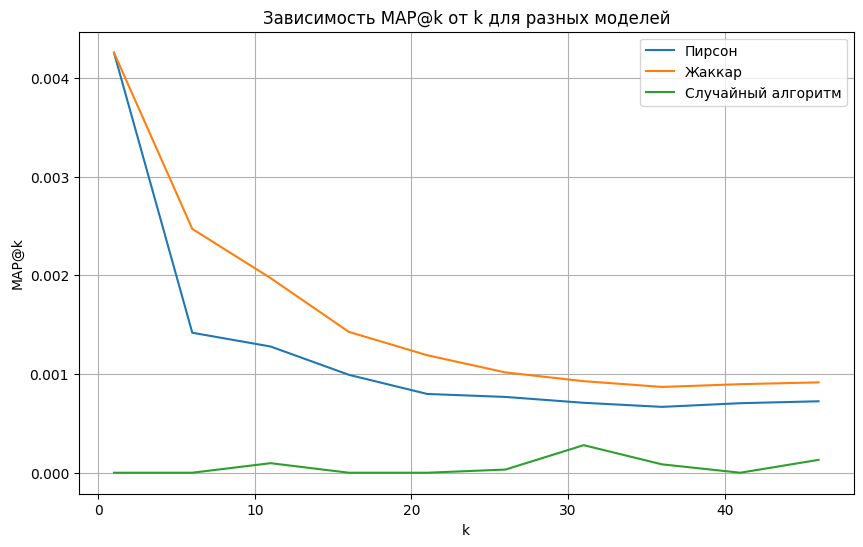

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(ks, pearson_scores, label="Пирсон")
plt.plot(ks, jaccard_scores, label="Жаккар")
plt.plot(ks, random_scores,  label="Случайный алгоритм")
plt.xlabel("k")
plt.ylabel("MAP@k")
plt.title("Зависимость MAP@k от k для разных моделей")
plt.legend()
plt.grid()
plt.show()

**Вывод:** Жаккар и Пирсон показывают заметно лучшие значения MAP@k по сравнению со случайным алгоритмом на значениях k от 1 до 100. Значит коллаборативная фильтрация действительно находит более релевантные треки по сравнению со случайным угадыванием. По графику также видно, что значения MAP@k для Жаккара оказываются выше, чем для Пирсона, особенно на малых значениях k. Также можно отметить, что в целом абсолютные значения MAP@k очень малы (в целом типично для рекомендаций, где доля известных релевантных треков пользователя очень мала по сравнению с общим числом треков).

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [18]:
import scipy.sparse as sp

def ratings_to_sparse_matrix(ratings_df, n_users, n_items):
    rows = ratings_df['userId'].values
    cols = ratings_df['trackId'].values
    data = np.ones(len(ratings_df), dtype=np.int8)
    R = sp.csr_matrix((data, (rows, cols)), shape=(n_users, n_items))
    return R

In [19]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(ratings['userId']))
        self.n_items = len(np.unique(ratings['trackId']))
        self.R = ratings_to_sparse_matrix(ratings, self.n_users, self.n_items)

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for uid in range(self.n_users):
            recs = self.recommend(uid)
            train_user_items = set(self.ratings[self.ratings['userId'] == uid]['trackId'])
            filtered_recs = [item for item in recs if item not in train_user_items]
            test_preds.append(filtered_recs[:k])
        return test_preds

In [20]:
def pearson_sparse(ratings: sp.csr_matrix, user_vector: sp.csr_matrix) -> np.array:
    """
    ratings: (num_users, num_items) csr_matrix
    user_vector: (1, num_items) csr_matrix
    """
    numerator = ratings.multiply(user_vector).sum(axis=1).A1
    norm_user = np.sqrt(user_vector.multiply(user_vector).sum())
    norm_others = np.sqrt(ratings.multiply(ratings).sum(axis=1)).A1
    denominator = norm_user * norm_others
    similarity = np.zeros_like(numerator, dtype=float)
    valid = denominator > 0
    similarity[valid] = numerator[valid] / denominator[valid]
    return similarity

def jaccard_sparse(ratings: sp.csr_matrix, user_vector: sp.csr_matrix) -> np.array:
    """
    ratings: (num_users, num_items) csr_matrix
    user_vector: (1, num_items) csr_matrix
    """
    intersection = ratings.multiply(user_vector).sum(axis=1).A1
    ratings_sum = ratings.sum(axis=1).A1
    user_vector_sum = user_vector.sum()
    union = ratings_sum + user_vector_sum - intersection
    similarity = np.zeros_like(intersection, dtype=float)
    valid = union > 0
    similarity[valid] = intersection[valid] / union[valid]
    return similarity

In [21]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)
        assert similarity_func in [pearson_sparse, jaccard_sparse]
        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: sp.csr_matrix) -> np.array:
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R.getrow(uid)
        sim_vec = self.similarity(user_vector)
        sim_vec[uid] = -np.inf

        neighbors = np.where(sim_vec > self.alpha)[0]
        if len(neighbors) == 0:
            neighbors = np.where(sim_vec > 0)[0]
        if len(neighbors) == 0:
            neighbors = np.setdiff1d(np.arange(self.n_users), [uid])

        sims = sim_vec[neighbors]
        R_neighbors = self.R[neighbors]
        numerator = R_neighbors.multiply(sims[:, None]).sum(axis=0).A1
        denominator = np.abs(sims).sum() + 1e-8
        scores = numerator / denominator
        ranked_items = np.argsort(scores)[::-1]
        return ranked_items

In [22]:
import time

R_dense = train_ratings
start = time.time()
_ = pearson(R_dense, R_dense.loc[0])
print("Dense time:", time.time() - start)

R_sparse = ratings_to_sparse_matrix(train_ratings, len(np.unique(ratings['userId'])), len(np.unique(ratings['trackId'])))
start = time.time()
_ = pearson_sparse(R_sparse, R_sparse.getrow(0))
print("Sparse time:", time.time() - start)

Dense time: 0.04850006103515625
Sparse time: 0.004171609878540039


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [26]:
model = User2User(train_ratings, jaccard_sparse)
user_id = np.random.randint(0, model.n_users)

In [27]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
1672,Song 2,['Blur']
1909,В наших глазах,['КИНО']
5512,Выхода нет,['Сплин']
5582,Улица роз,['Ария']
5872,Я свободен,['Кипелов']
6980,Cheri Cheri Lady,['Modern Talking']
8057,Get Low,"['Lil Jon & The East Side Boyz', 'Ying Yang Tw..."
9438,Что такое осень,['ДДТ']
10890,Glad You Came,['The Wanted']
15242,Батарейка,['Жуки']


In [28]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
18459,Take Me To Church,['Hozier']
46353,Hokage,['Big Baby Tape']
48183,Улети,['T-Fest']
59915,Friendly Fire,['Boulevard Depo']
29169,Heathens,['twenty one pilots']
28807,Рапапам,"['9 грамм', 'Miyagi & Эндшпиль']"
1073,Smells Like Teen Spirit,['Nirvana']
48246,Положение,['Скриптонит']
31778,Жить в кайф,['Макс Корж']
33828,Mask Off,['Future']


In [29]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
59071,Я дома,['Даня Милохин']
59111,Колхозник,['Mnogoznaal']
59422,Hypnodancer,['Little Big']
59495,Папа,['PUSSYKILLER']
59499,ОЙ,['SQWOZ BAB']
59583,Comatose,['jxdn']
59695,Диор,['EXCE$$']
59718,GASOLINE,"['SLVG', 'REDZED']"
59776,I CAN KICK IT,"['GONE.Fludd', 'bbno$']"
59847,"this is Jesus, he is God",['TSGD']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_i \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастическим градиентным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Вспомните формулы обновления и поясните их:

**SGD:**

На каждом шаге для известной оценки $(u, i)$ вычисляют ошибку предсказания:
$$
e_{ui} = r_{ui} - \langle p_u, q_i \rangle
$$
где $p_u$ и $q_i$ — латентные векторы пользователя $u$ и объекта $i$ соответственно, а $r_{ui}$ — наблюдаемая оценка.

Векторы обновляют по формулам:
$$
p_u \leftarrow p_u + \eta \left( e_{ui} \cdot q_i - \lambda p_u \right)
$$
$$
q_i \leftarrow q_i + \eta \left( e_{ui} \cdot p_u - \lambda q_i \right)
$$
где $\eta$ — learning rate, $\lambda$ — коэффициент регуляризации.

SGD минимизирует ошибку предсказания на каждой паре данных, меняя параметры только для них. Регуляризация не даёт векторам разрастаться и переобучаться. Делается несколько проходов по всем парам (эпох).

**ALS:**

Пусть $I_u$ — множество всех объектов, с которыми взаимодействовал пользователь $u$.

Обновление латентного вектора пользователя $p_u$ при фиксированных $q_i$:
$$
p_u \leftarrow \left( \sum_{i \in I_u} q_i q_i^T + \lambda I \right)^{-1}
            \left( \sum_{i \in I_u} r_{ui} q_i \right)
$$
где $\lambda$ — коэффициент регуляризации.

Пусть $U_i$ — множество всех пользователей, взаимодействовавших с объектом $i$.

Обновление латентного вектора объекта $q_i$ при фиксированных $p_u$:
$$
q_i \leftarrow \left( \sum_{u \in U_i} p_u p_u^T + \lambda I \right)^{-1}
            \left( \sum_{u \in U_i} r_{ui} p_u \right)
$$
где $\lambda$ — коэффициент регуляризации.

ALS поочерёдно оптимизирует параметры пользователей и объектов. Когда мы фиксируем вектора объектов, оптимальные вектора пользователей находятся как решение системы линейных уравнений, и наоборот. Такой подход отлично подходит для разреженных данных.

**Задание 8 (2 балла).** А теперь реализуйте методы оптимизации параметров для обоих алгоритмов.

In [30]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        if self.mode == 'sgd':
            ui = np.array(self.ratings[['userId', 'trackId']].values, dtype=int)
            for epoch in tqdm(range(num_iters)):
                np.random.shuffle(ui)
                for u, i in ui:
                    p_u = self.P[u]
                    q_i = self.Q[i]
                    r_ui = 1
                    r_hat = np.dot(p_u, q_i)
                    err = r_ui - r_hat
                    self.P[u] += self.lr * (err * q_i - self.lamb * p_u)
                    self.Q[i] += self.lr * (err * p_u - self.lamb * q_i)

        elif self.mode == 'als':
            from collections import defaultdict
            user2items = defaultdict(list)
            item2users = defaultdict(list)
            for _, row in self.ratings.iterrows():
                u, i = int(row['userId']), int(row['trackId'])
                user2items[u].append(i)
                item2users[i].append(u)

            for epoch in tqdm(range(num_iters)):
                QtQ = self.Q.T @ self.Q
                for u in range(self.n_users):
                    items = user2items[u]
                    if not items: continue
                    Q_I = self.Q[items]
                    A = QtQ + self.lamb * np.eye(self.dim)
                    b = np.sum(Q_I, axis=0)
                    self.P[u] = np.linalg.solve(
                        Q_I.T @ Q_I + self.lamb * np.eye(self.dim),
                        Q_I.T @ np.ones(len(items))
                    )

                PtP = self.P.T @ self.P
                for i in range(self.n_items):
                    users = item2users[i]
                    if not users: continue
                    P_U = self.P[users]
                    self.Q[i] = np.linalg.solve(
                        P_U.T @ P_U + self.lamb * np.eye(self.dim),
                        P_U.T @ np.ones(len(users))
                    )

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [31]:
dims = [32, 64, 128]
ks = [1, 5, 10, 20]
num_iters_list = [1, 3, 5, 10]

results = []

for mode in ['sgd', 'als']:
    for dim in dims:
        for num_iters in num_iters_list:
            model = HiddenVars(train_ratings, dim=dim, mode=mode)
            model.fit(num_iters=num_iters)
            for k in ks:
                preds = model.get_test_recommendations(k)
                val_map = mapk(test_relevant, preds, k)
                results.append({
                    'mode': mode,
                    'dim': dim,
                    'num_iters': num_iters,
                    'k': k,
                    'MAP@k': val_map
                })
                print(f'{mode}, dim={dim}, num_iter={num_iters}, k={k}: MAP@k={val_map:.4f}')
df_results = pd.DataFrame(results)

  0%|          | 0/1 [00:00<?, ?it/s]

sgd, dim=32, num_iter=1, k=1: MAP@k=0.0000
sgd, dim=32, num_iter=1, k=5: MAP@k=0.0000
sgd, dim=32, num_iter=1, k=10: MAP@k=0.0001
sgd, dim=32, num_iter=1, k=20: MAP@k=0.0000


  0%|          | 0/3 [00:00<?, ?it/s]

sgd, dim=32, num_iter=3, k=1: MAP@k=0.0000
sgd, dim=32, num_iter=3, k=5: MAP@k=0.0000
sgd, dim=32, num_iter=3, k=10: MAP@k=0.0000
sgd, dim=32, num_iter=3, k=20: MAP@k=0.0000


  0%|          | 0/5 [00:00<?, ?it/s]

sgd, dim=32, num_iter=5, k=1: MAP@k=0.0000
sgd, dim=32, num_iter=5, k=5: MAP@k=0.0000
sgd, dim=32, num_iter=5, k=10: MAP@k=0.0001
sgd, dim=32, num_iter=5, k=20: MAP@k=0.0000


  0%|          | 0/10 [00:00<?, ?it/s]

sgd, dim=32, num_iter=10, k=1: MAP@k=0.0000
sgd, dim=32, num_iter=10, k=5: MAP@k=0.0006
sgd, dim=32, num_iter=10, k=10: MAP@k=0.0003
sgd, dim=32, num_iter=10, k=20: MAP@k=0.0002


  0%|          | 0/1 [00:00<?, ?it/s]

sgd, dim=64, num_iter=1, k=1: MAP@k=0.0000
sgd, dim=64, num_iter=1, k=5: MAP@k=0.0000
sgd, dim=64, num_iter=1, k=10: MAP@k=0.0000
sgd, dim=64, num_iter=1, k=20: MAP@k=0.0000


  0%|          | 0/3 [00:00<?, ?it/s]

sgd, dim=64, num_iter=3, k=1: MAP@k=0.0000
sgd, dim=64, num_iter=3, k=5: MAP@k=0.0000
sgd, dim=64, num_iter=3, k=10: MAP@k=0.0001
sgd, dim=64, num_iter=3, k=20: MAP@k=0.0000


  0%|          | 0/5 [00:00<?, ?it/s]

sgd, dim=64, num_iter=5, k=1: MAP@k=0.0000
sgd, dim=64, num_iter=5, k=5: MAP@k=0.0000
sgd, dim=64, num_iter=5, k=10: MAP@k=0.0000
sgd, dim=64, num_iter=5, k=20: MAP@k=0.0000


  0%|          | 0/10 [00:00<?, ?it/s]

sgd, dim=64, num_iter=10, k=1: MAP@k=0.0000
sgd, dim=64, num_iter=10, k=5: MAP@k=0.0000
sgd, dim=64, num_iter=10, k=10: MAP@k=0.0000
sgd, dim=64, num_iter=10, k=20: MAP@k=0.0000


  0%|          | 0/1 [00:00<?, ?it/s]

sgd, dim=128, num_iter=1, k=1: MAP@k=0.0000
sgd, dim=128, num_iter=1, k=5: MAP@k=0.0004
sgd, dim=128, num_iter=1, k=10: MAP@k=0.0002
sgd, dim=128, num_iter=1, k=20: MAP@k=0.0001


  0%|          | 0/3 [00:00<?, ?it/s]

sgd, dim=128, num_iter=3, k=1: MAP@k=0.0000
sgd, dim=128, num_iter=3, k=5: MAP@k=0.0000
sgd, dim=128, num_iter=3, k=10: MAP@k=0.0001
sgd, dim=128, num_iter=3, k=20: MAP@k=0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

sgd, dim=128, num_iter=5, k=1: MAP@k=0.0043
sgd, dim=128, num_iter=5, k=5: MAP@k=0.0009
sgd, dim=128, num_iter=5, k=10: MAP@k=0.0004
sgd, dim=128, num_iter=5, k=20: MAP@k=0.0003


  0%|          | 0/10 [00:00<?, ?it/s]

sgd, dim=128, num_iter=10, k=1: MAP@k=0.0000
sgd, dim=128, num_iter=10, k=5: MAP@k=0.0003
sgd, dim=128, num_iter=10, k=10: MAP@k=0.0001
sgd, dim=128, num_iter=10, k=20: MAP@k=0.0001


  0%|          | 0/1 [00:00<?, ?it/s]

als, dim=32, num_iter=1, k=1: MAP@k=0.0085
als, dim=32, num_iter=1, k=5: MAP@k=0.0023
als, dim=32, num_iter=1, k=10: MAP@k=0.0014
als, dim=32, num_iter=1, k=20: MAP@k=0.0008


  0%|          | 0/3 [00:00<?, ?it/s]

als, dim=32, num_iter=3, k=1: MAP@k=0.0000
als, dim=32, num_iter=3, k=5: MAP@k=0.0004
als, dim=32, num_iter=3, k=10: MAP@k=0.0005
als, dim=32, num_iter=3, k=20: MAP@k=0.0003


  0%|          | 0/5 [00:00<?, ?it/s]

als, dim=32, num_iter=5, k=1: MAP@k=0.0043
als, dim=32, num_iter=5, k=5: MAP@k=0.0019
als, dim=32, num_iter=5, k=10: MAP@k=0.0011
als, dim=32, num_iter=5, k=20: MAP@k=0.0006


  0%|          | 0/10 [00:00<?, ?it/s]

als, dim=32, num_iter=10, k=1: MAP@k=0.0000
als, dim=32, num_iter=10, k=5: MAP@k=0.0008
als, dim=32, num_iter=10, k=10: MAP@k=0.0005
als, dim=32, num_iter=10, k=20: MAP@k=0.0003


  0%|          | 0/1 [00:00<?, ?it/s]

als, dim=64, num_iter=1, k=1: MAP@k=0.0043
als, dim=64, num_iter=1, k=5: MAP@k=0.0018
als, dim=64, num_iter=1, k=10: MAP@k=0.0011
als, dim=64, num_iter=1, k=20: MAP@k=0.0007


  0%|          | 0/3 [00:00<?, ?it/s]

als, dim=64, num_iter=3, k=1: MAP@k=0.0000
als, dim=64, num_iter=3, k=5: MAP@k=0.0015
als, dim=64, num_iter=3, k=10: MAP@k=0.0010
als, dim=64, num_iter=3, k=20: MAP@k=0.0007


  0%|          | 0/5 [00:00<?, ?it/s]

als, dim=64, num_iter=5, k=1: MAP@k=0.0043
als, dim=64, num_iter=5, k=5: MAP@k=0.0022
als, dim=64, num_iter=5, k=10: MAP@k=0.0014
als, dim=64, num_iter=5, k=20: MAP@k=0.0007


  0%|          | 0/10 [00:00<?, ?it/s]

als, dim=64, num_iter=10, k=1: MAP@k=0.0085
als, dim=64, num_iter=10, k=5: MAP@k=0.0024
als, dim=64, num_iter=10, k=10: MAP@k=0.0015
als, dim=64, num_iter=10, k=20: MAP@k=0.0008


  0%|          | 0/1 [00:00<?, ?it/s]

als, dim=128, num_iter=1, k=1: MAP@k=0.0000
als, dim=128, num_iter=1, k=5: MAP@k=0.0000
als, dim=128, num_iter=1, k=10: MAP@k=0.0003
als, dim=128, num_iter=1, k=20: MAP@k=0.0002


  0%|          | 0/3 [00:00<?, ?it/s]

als, dim=128, num_iter=3, k=1: MAP@k=0.0085
als, dim=128, num_iter=3, k=5: MAP@k=0.0026
als, dim=128, num_iter=3, k=10: MAP@k=0.0014
als, dim=128, num_iter=3, k=20: MAP@k=0.0008


  0%|          | 0/5 [00:00<?, ?it/s]

als, dim=128, num_iter=5, k=1: MAP@k=0.0000
als, dim=128, num_iter=5, k=5: MAP@k=0.0007
als, dim=128, num_iter=5, k=10: MAP@k=0.0007
als, dim=128, num_iter=5, k=20: MAP@k=0.0005


  0%|          | 0/10 [00:00<?, ?it/s]

als, dim=128, num_iter=10, k=1: MAP@k=0.0043
als, dim=128, num_iter=10, k=5: MAP@k=0.0016
als, dim=128, num_iter=10, k=10: MAP@k=0.0009
als, dim=128, num_iter=10, k=20: MAP@k=0.0006


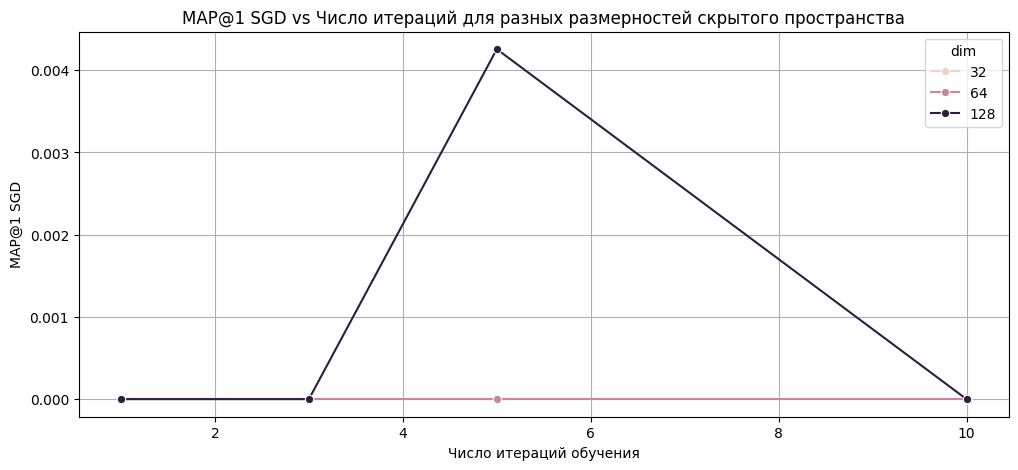

In [36]:
import seaborn as sns

plt.figure(figsize=(12, 5))
for mode in ['sgd']:
    subset = df_results[(df_results['mode'] == mode) & (df_results['k'] == 1)]
    sns.lineplot(x='num_iters', y='MAP@k', hue='dim', data=subset, marker='o')

plt.title('MAP@1 SGD vs Число итераций для разных размерностей скрытого пространства')
plt.xlabel('Число итераций обучения')
plt.ylabel('MAP@1 SGD')
plt.legend(title='dim')
plt.grid()
plt.show()

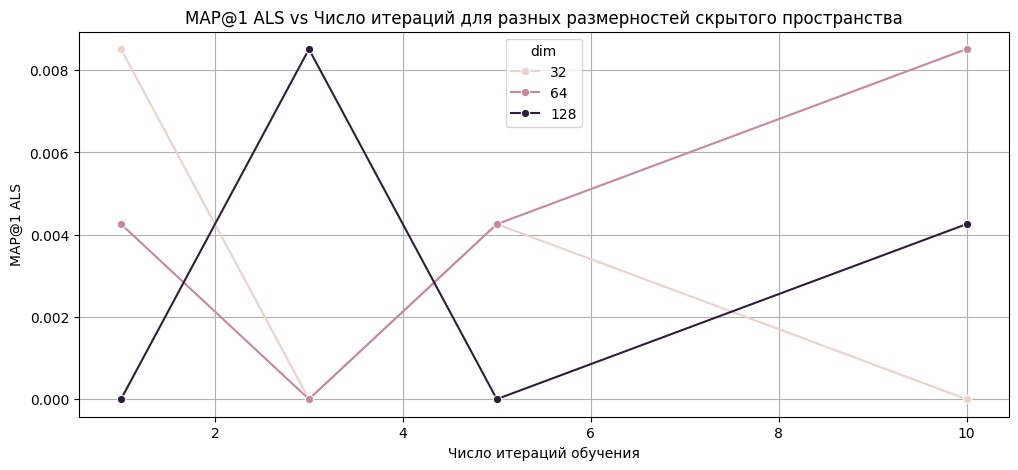

In [40]:
import seaborn as sns

plt.figure(figsize=(12, 5))
for mode in ['als']:
    subset = df_results[(df_results['mode'] == mode) & (df_results['k'] == 1)]
    sns.lineplot(x='num_iters', y='MAP@k', hue='dim', data=subset, marker='o')

plt.title('MAP@1 ALS vs Число итераций для разных размерностей скрытого пространства')
plt.xlabel('Число итераций обучения')
plt.ylabel('MAP@1 ALS')
plt.legend(title='dim')
plt.grid()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SGD-LFM: MAP@1 = 0.0000
ALS-LFM: MAP@1 = 0.0128
User2User: MAP@1 = 0.0043
Random: MAP@1 = 0.0000


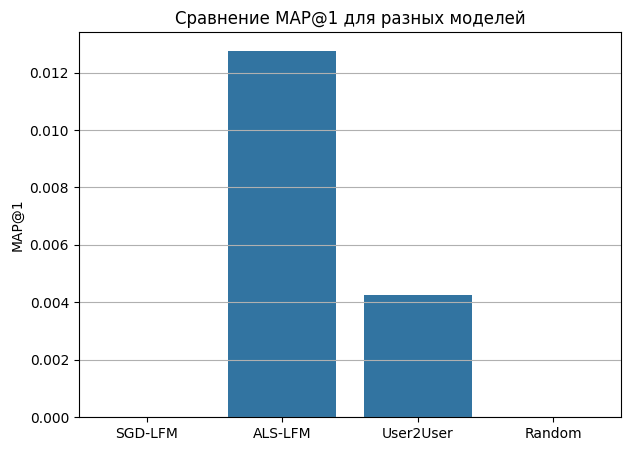

In [52]:
k_best = 1
best_dim = df_results.groupby(['mode', 'dim'])['MAP@k'].max().reset_index().sort_values('MAP@k', ascending=False).iloc[0]['dim']
print(best_dim)
sgd_model = HiddenVars(train_ratings, dim=best_dim, mode='sgd')
sgd_model.fit(num_iters=1)
als_model = HiddenVars(train_ratings, dim=best_dim, mode='als')
als_model.fit(num_iters=1)

user2user_model = User2User(train_ratings, pearson_sparse)
random_model = RandomModel(train_ratings)

models = [
    ("SGD-LFM", sgd_model),
    ("ALS-LFM", als_model),
    ("User2User", user2user_model),
    ("Random", random_model)
]

map_results = {}
for name, model in models:
    preds = model.get_test_recommendations(k_best)
    score = mapk(test_relevant, preds, k_best)
    map_results[name] = score
    print(f"{name}: MAP@{k_best} = {score:.4f}")

plt.figure(figsize=(7, 5))
sns.barplot(x=list(map_results.keys()), y=list(map_results.values()))
plt.ylabel(f'MAP@{k_best}')
plt.title(f'Сравнение MAP@{k_best} для разных моделей')
plt.grid(axis='y')
plt.show()


**Вывод:** с увеличением числа итераций обучения качество предсказаний заметной падает (характерно для разных размерностей). Исходя из построенных графиков и полученных результатов для k = 1 можно сделать вывод, что алгоритм ALS наилучшим образом справляется с задачей рекомендаций (существенно лучше User2User и случайного алгоритма), в то время как SGD показывает посредственные результаты. Вероятно преимущество ALS обуславливается его устойчивостью к разреженности и хорошему выучиванию каких-то скрытых факторов.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров матрицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [53]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = als_model.Q @ als_model.Q[example_trackId]
preds = preds / np.sqrt((als_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [55]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(als_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
36913,Оптимист,['Макс Корж'],0.721218
16192,Однажды мир прогнётся под нас,['Машина времени'],0.707341
2058,Последний герой,['КИНО'],0.702062
41236,Иордан,"['Noize MC', 'Atlantida Project']",0.695879
5528,Red Stars,['The Birthday Massacre'],0.694250
1068,Take Me,['Papa Roach'],0.685110
24793,Wash It All Away,['Five Finger Death Punch'],0.675960
862,Some Say,['Sum 41'],0.661027
11485,I Want To Break Free,['Queen'],0.659052
